In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
file_path = 'forestfires.csv'
df = pd.read_csv(file_path)

# Remove the specified columns
df.drop(columns=['rain', 'X', 'Y', 'day'], inplace=True)

# Convert months to a binary summer category
def is_summer(month):
    return int(month in ['jun', 'jul', 'aug'])

df['is_summer'] = df['month'].apply(is_summer)
df.drop(columns='month', inplace=True)

# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]

numeric_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'area']
df = remove_outliers_iqr(df, numeric_features)

# Apply log transformation to the target variable
df['log_area'] = np.log1p(df['area'])

# Create new features
df['temp_RH_interaction'] = df['temp'] * df['RH']
df['wind_ISI_interaction'] = df['wind'] * df['ISI']

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[numeric_features[:-1]])
poly_feature_names = [f"poly_{i}" for i in range(poly_features.shape[1])]

# Combine polynomial features with the original data
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
df = pd.concat([df, df_poly], axis=1)

# Check for and handle NaN or infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Split the data into features and target
X = df.drop(columns=['area', 'log_area'])
y = df['log_area']

# Normalize the numeric features
scaler = StandardScaler()
X[numeric_features[:-1]] = scaler.fit_transform(X[numeric_features[:-1]])

# Convert to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [21]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Define the model architecture based on hyperparameters
    class TrialNeuralNetwork(nn.Module):
        def __init__(self, input_dim):
            super(TrialNeuralNetwork, self).__init__()
            hidden_size1 = trial.suggest_int('hidden_size1', 128, 512)
            hidden_size2 = trial.suggest_int('hidden_size2', 64, 256)
            hidden_size3 = trial.suggest_int('hidden_size3', 32, 128)
            dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
            self.fc1 = nn.Linear(input_dim, hidden_size1)
            self.bn1 = nn.BatchNorm1d(hidden_size1)
            self.fc2 = nn.Linear(hidden_size1, hidden_size2)
            self.bn2 = nn.BatchNorm1d(hidden_size2)
            self.fc3 = nn.Linear(hidden_size2, hidden_size3)
            self.bn3 = nn.BatchNorm1d(hidden_size3)
            self.fc4 = nn.Linear(hidden_size3, 1)
            self.dropout = nn.Dropout(dropout_rate)
            
        def forward(self, x):
            x = torch.relu(self.bn1(self.fc1(x)))
            x = self.dropout(x)
            x = torch.relu(self.bn2(self.fc2(x)))
            x = self.dropout(x)
            x = torch.relu(self.bn3(self.fc3(x)))
            x = self.fc4(x)
            return x
    
    input_dim = X_train.shape[1]
    model = TrialNeuralNetwork(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float('lr', 1e-4, 1e-2))
    
    # Train the model
    def train_model(trial, model, criterion, optimizer, train_loader, val_loader, num_epochs=50):
        model.train()
        best_val_loss = float('inf')
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.flatten(), targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs.flatten(), val_targets).item()
            val_loss /= len(val_loader)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
        
        return best_val_loss
    
    # Split the data
    X_train_torch, X_val_torch, y_train_torch, y_val_torch = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    train_dataset = TensorDataset(X_train_torch, y_train_torch)
    val_dataset = TensorDataset(X_val_torch, y_val_torch)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    val_loss = train_model(trial, model, criterion, optimizer, train_loader, val_loader, num_epochs=50)
    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print(study.best_params)

c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-07 14:05:00,566] A new study created in memory with name: no-name-d34e0f63-30b0-456b-9034-6e9a6e5fdd73
[I 2024-06-07 14:05:01,610] Trial 0 finished with value: 0.645013302564621 and parameters: {'hidden_size1': 234, 'hidden_size2': 200, 'hidden_size3': 73, 'dropout_rate': 0.4515143846051031, 'lr': 0.008990098673274669}. Best is trial 0 with value: 0.645013302564621.
[I 2024-06-07 14:05:02,535] Trial 1 finished with value: 0.5892947614192963 and parameters: {'hidden_size1': 385, 'hidden_size2': 158, 'hidden_size3': 55, 'dropout_rate': 0.28871129168367005, 'lr': 0.005142822472766933}. Best is trial 1 with value: 0.5892947614192963.
[I 2024-06-07 14:05:03,459] Trial 2 finished with value: 0.5596309900283813 and parame

{'hidden_size1': 362, 'hidden_size2': 208, 'hidden_size3': 123, 'dropout_rate': 0.35067529408981657, 'lr': 0.0029387879149631504}


In [22]:
# Use the best hyperparameters to train the final model
best_params = study.best_params
class BestNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BestNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, best_params['hidden_size1'])
        self.bn1 = nn.BatchNorm1d(best_params['hidden_size1'])
        self.fc2 = nn.Linear(best_params['hidden_size1'], best_params['hidden_size2'])
        self.bn2 = nn.BatchNorm1d(best_params['hidden_size2'])
        self.fc3 = nn.Linear(best_params['hidden_size2'], best_params['hidden_size3'])
        self.bn3 = nn.BatchNorm1d(best_params['hidden_size3'])
        self.fc4 = nn.Linear(best_params['hidden_size3'], 1)
        self.dropout = nn.Dropout(best_params['dropout_rate'])
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Initialize and train the final model with best hyperparameters
input_dim = X_train.shape[1]
final_model = BestNeuralNetwork(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])

train_model_with_early_stopping(final_model, criterion, optimizer, train_loader, val_loader, num_epochs=200, patience=10)

# Evaluate the final model
final_model.load_state_dict(torch.load('best_model.pth'))
y_true, y_pred = evaluate_model(final_model, test_loader)

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Optimized PyTorch Model Test RMSE: {rmse}")
print(f"Optimized PyTorch Model Test MAE: {mae}")
print(f"Optimized PyTorch Model Test R²: {r2}")

Epoch [1/200], Training Loss: 0.9567, Validation Loss: 0.8589
Epoch [2/200], Training Loss: 0.9936, Validation Loss: 0.7736
Epoch [3/200], Training Loss: 0.7509, Validation Loss: 0.6851
Epoch [4/200], Training Loss: 0.7276, Validation Loss: 0.6687
Epoch [5/200], Training Loss: 0.7145, Validation Loss: 0.6790
Epoch [6/200], Training Loss: 0.7654, Validation Loss: 0.7593
Epoch [7/200], Training Loss: 0.7829, Validation Loss: 0.6897
Epoch [8/200], Training Loss: 0.7056, Validation Loss: 0.7434
Epoch [9/200], Training Loss: 0.6585, Validation Loss: 0.6440
Epoch [10/200], Training Loss: 0.6589, Validation Loss: 0.6338
Epoch [11/200], Training Loss: 0.6024, Validation Loss: 0.5919
Epoch [12/200], Training Loss: 0.6067, Validation Loss: 0.6533
Epoch [13/200], Training Loss: 0.5969, Validation Loss: 0.5572
Epoch [14/200], Training Loss: 0.5885, Validation Loss: 0.6338
Epoch [15/200], Training Loss: 0.5664, Validation Loss: 0.5233
Epoch [16/200], Training Loss: 0.5730, Validation Loss: 0.7760
E

c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


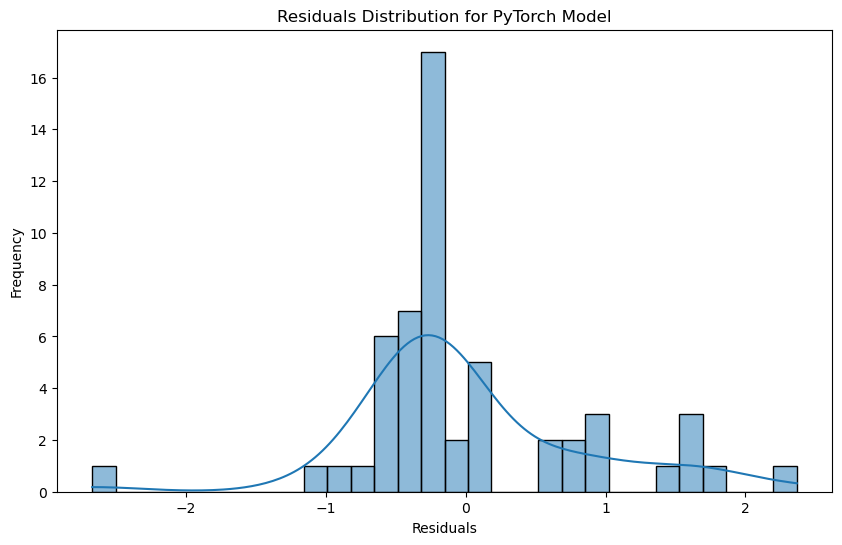

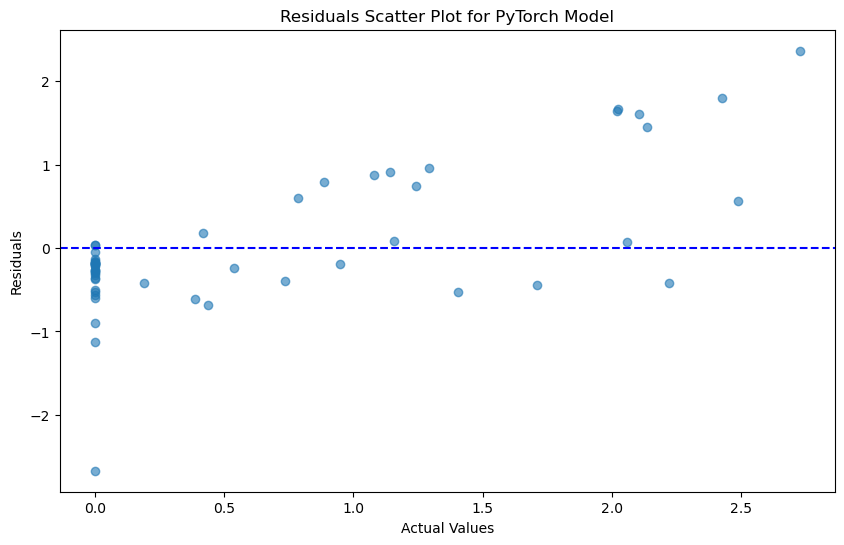

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals for PyTorch model
final_model.load_state_dict(torch.load('best_model.pth'))
final_model.eval()
with torch.no_grad():
    y_pred_pytorch = final_model(X_test).cpu().numpy().flatten()
residuals_pytorch = y_test.cpu().numpy() - y_pred_pytorch

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_pytorch, kde=True, bins=30)
plt.title('Residuals Distribution for PyTorch Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test.cpu().numpy(), residuals_pytorch, alpha=0.6)
plt.axhline(y=0, color='blue', linestyle='--')
plt.title('Residuals Scatter Plot for PyTorch Model')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()
